In [17]:
import os
from collections import defaultdict
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ("CI" in os.environ)
#assert pyro.__version__.startswith('1.2.0')
pyro.enable_validation(True)

In [20]:
K = 2
@config_enumerate
def model(N):
    # global variables
    α = 0.5
    θ = pyro.sample("θ", dist.Dirichlet(α * torch.ones(K)))
    σ = 1.0
    σ_0 = 10.
    with pyro.plate('components', K):
        μ = pyro.sample('μ', dist.Normal(0., σ_0))
    
    with pyro.plate('data', N):
        Z = pyro.sample("Z", dist.Categorical(θ))
        X = pyro.sample("X", dist.Normal(μ[Z], σ))
    return {'X': X, 'Z': Z}

In [21]:
model(4)

{'X': tensor([14.0047, 13.8747, 13.0961, 12.5326]), 'Z': tensor([0, 0, 0, 0])}

# Interventions

Since this is a causal model, we can apply interventions. Pyro has a pyro.do function that will take in a model, and return a modified model that reflects the intervention. It does this by replacing whatever sampling statement was used to generate the intervention target in the model iwth a statement that fixes that value to the intervention value.

In this code, we set the values of Z to [0,1,1,0,1,1,1,1,1,1], then generate from the model

In [22]:
intervention = torch.tensor([0,1,1,0,1, 1,1,1,1,1])
intervention_model = pyro.do(model, data={"Z": intervention})
intervention_model(10)

{'X': tensor([0.7632, 7.0987, 5.4986, 0.4045, 5.7708, 6.0320, 4.2104, 5.4908, 6.3008,
         5.5077]),
 'Z': tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])}

# Training the Greeks

In latent variable modeling, the modeler generally doesn't know the values of the Greek variables. In our case, we used probability distribution to capture that uncertainty.

In practice, modelers try to infer their values from training data (i.e. the values of Zs and Xs).In other words, we treat the Greeks as weights in a training step.

There are several ways to learn these parameters from data. Getting maximum likelihood estimates using expectation maximization is a common way. Here, since we are thinking as Bayesians, we use Bayesian inference.

... SVI...

This implementation finds MAP estimates.

In [52]:
data = torch.tensor([0., 1., 10., 11., 12.])
N = len(data)
K = 2 # fixed number of components
evidence_model = pyro.condition(model, data={'X': data})

optim = Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

def init_loc_fn(site):
    if site['name'] == 'θ':
        # initialize the weights to uniform
        return torch.ones(K) / K
    if site['name'] == 'μ':
        return data[torch.multinomial(torch.ones(N)/N, K)]
    raise ValueError(site['name'])

In [53]:
def initialize(seed):
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(evidence_model, expose=['θ', 'μ']),
                            init_loc_fn=init_loc_fn)
    svi = SVI(evidence_model, global_guide, optim, loss=elbo)
    return svi.loss(evidence_model, global_guide, N)


In [61]:
for seed in range(100):
    print(seed, initialize(seed))

0 106.22805786132812
1 165.01177978515625
2 18.675058364868164
3 18.455059051513672
4 105.91038513183594
5 17.065059661865234
6 106.22805786132812
7 18.460060119628906
8 105.91038513183594
9 18.680057525634766
10 17.065059661865234
11 18.675058364868164
12 105.91038513183594
13 17.065059661865234
14 18.460060119628906
15 18.460060119628906
16 18.460060119628906
17 105.91038513183594
18 18.675058364868164
19 17.06005859375
20 105.91038513183594
21 17.06005859375
22 18.680057525634766
23 18.460060119628906
24 17.06005859375
25 17.06005859375
26 105.91038513183594
27 18.680057525634766
28 18.455059051513672
29 18.680057525634766
30 18.680057525634766
31 18.675058364868164
32 18.455059051513672
33 106.22805786132812
34 106.22805786132812
35 18.455059051513672
36 18.675058364868164
37 18.460060119628906
38 17.06005859375
39 165.01177978515625
40 18.680057525634766
41 18.680057525634766
42 165.01177978515625
43 17.065059661865234
44 105.91038513183594
45 18.460060119628906
46 165.01177978515

In [54]:
loss, seed = min((initialize(seed), seed) for seed in range(100))

In [55]:
initialize(seed)

17.06005859375

In [56]:
print('seed = {}, initial loss = {}'.format(seed, loss))

seed = 19, initial loss = 17.06005859375


In [57]:
# register hooks to monitor gradient norms
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))
    

In [58]:
losses = []
for i in range(200):
    loss = svi.step(N)
    losses.append(loss)
    print('.' if i%100 else '\n', end='')



...................................................................................................
...................................................................................................

In [59]:
map_estimates = global_guide(N)

In [60]:
θ = map_estimates['θ']
μ = map_estimates['μ']
print('\n')
print('θ = {}'.format(θ.data.numpy()))
print('μ = {}'.format(μ.data.numpy()))



θ = [0.625 0.375]
μ = [10.96146     0.49751246]


In [63]:
import matplotlib.pyplot as plt

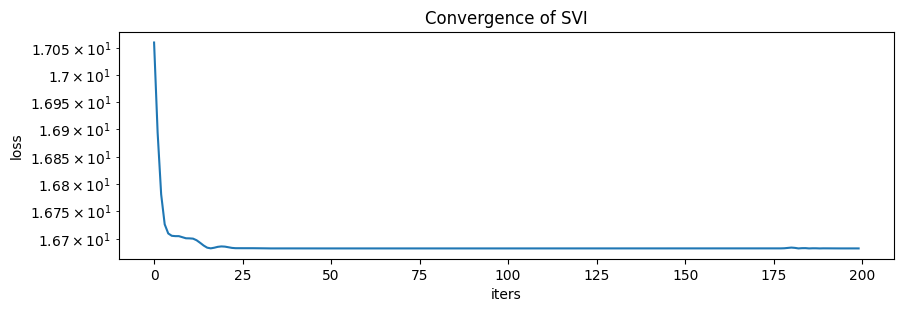

In [64]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');

Text(0, 0.5, 'probability density')

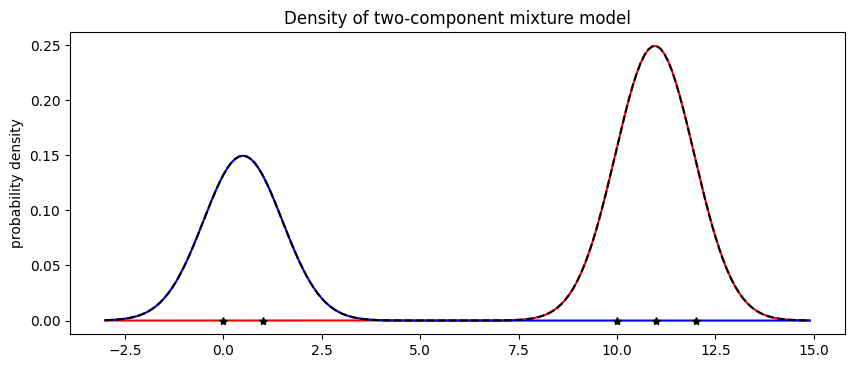

In [68]:
X = np.arange(-3,15,0.1)
Y1 = θ[0].item() * scipy.stats.norm.pdf((X - μ[0].item()))
Y2 = θ[1].item() * scipy.stats.norm.pdf((X - μ[1].item()))

plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
plt.plot(X, Y1, 'r-')
plt.plot(X, Y2, 'b-')
plt.plot(X, Y1 + Y2, 'k--')
plt.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
plt.title('Density of two-component mixture model')
plt.ylabel('probability density')